# Video Classification Using Transfer Learning | UCF101 - Action Recognition

In [ ]:
# pip install imageio tqdm opencv-python tensorflow

## Import Packages

In [1]:
import glob # glob is a Python module used for file pattern matching, allowing you to retrieve file paths that match a specified pattern (e.g., *.txt)
import pandas as pd
import cv2 # cv2 is a Python library that provides functions for image processing and computer vision tasks, such as reading, writing, and manipulating images, as well as performing tasks like object detection and feature extraction.
import gc # gc is a Python module that provides functions to interact with the garbage collection process, allowing manual control over memory management, such as forcing garbage collection or disabling it. It helps optimize memory usage and clean up unused objects.
import numpy as np
import random
import imageio # imageio is a Python library used for reading and writing image data, supporting a wide range of image formats and providing easy interfaces for handling images, videos, and volumes.
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Image  # display images and other rich media in Jupyter notebooks or IPython environments.display is used to render objects in the output cell. Image is used to display an image from a file or URL.
from sklearn.metrics import confusion_matrix, classification_report

# Configuration

In [2]:
# Configuration
epochs = 10
batch_size = 32
classes = ["ApplyEyeMakeup", "ApplyLipstick", "Archery"]

# Data Loading

In [4]:
# Load and process the dataset
file_paths, targets = [], []
for i, cls in enumerate(classes):
    video_files = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")
    file_paths.extend(video_files)
    targets.extend([i] * len(video_files))  # Keeping structure intact

In [6]:
file_paths[0:6]

['/kaggle/input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g19_c01.avi',
 '/kaggle/input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c05.avi',
 '/kaggle/input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g13_c02.avi',
 '/kaggle/input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c01.avi',
 '/kaggle/input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g12_c02.avi',
 '/kaggle/input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g21_c05.avi']

In [8]:
targets[:5]

[0, 0, 0, 0, 0]

In [10]:
# Use Keras-based resizing and scaling
def format_frames(frame, output_size=(224, 224)):
    frame = tf.keras.layers.Rescaling(1.0 / 255.0)(frame)  # Normalize pixel values to [0,1]
    frame = tf.image.resize_with_pad(frame, *output_size)  # Resize while maintaining aspect ratio with padding
    return frame

# Read and process video frames
def frames_from_video_file(video_path, n_frames=10, output_size=(224, 224), frame_step=15):
    result = []  # Store extracted frames
    src = cv2.VideoCapture(video_path)  # Open video file
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total number of frames in the video
    
    # Randomly select a starting frame within valid range
    start = random.randint(0, max(0, video_length - 1 - (n_frames - 1) * frame_step))
    src.set(cv2.CAP_PROP_POS_FRAMES, start)  # Set the video frame position to start point
    
    ret, frame = src.read()  # Read the first frame
    if ret:  # If frame is successfully read
        result.append(format_frames(frame, output_size))  # Process and store the frame
        
        for _ in range(n_frames - 1):  # Loop to extract remaining frames
            for _ in range(frame_step):  # Skip `frame_step` frames to maintain spacing
                src.read()  # Read and discard the skipped frames
            
            ret, frame = src.read()  # Read the next valid frame
            if ret:
                result.append(format_frames(frame, output_size))  # Process and store frame
            else:
                result.append(tf.zeros_like(result[0]))  # Add a black frame if the video ends early

    src.release()  # Release the video file
    return np.array(result)[..., [2, 1, 0]]  # Convert BGR to RGB format


# Prepare training and validation datasets
features = np.array([frames_from_video_file(f, n_frames=10) for f in tqdm(file_paths)])  # Extract frames from videos

# Convert targets into a NumPy array for compatibility
targets = np.array(targets)

  0%|          | 0/404 [00:00<?, ?it/s]

In [12]:
features.shape

(404, 10, 224, 224, 3)

In [14]:
targets.shape

(404,)

# Visualization

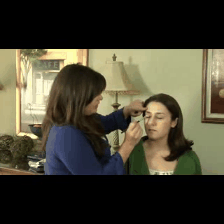

In [15]:
# Convert frames to GIF for visualization
def to_gif(images):
    images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', images, fps=10)
    display(Image(filename='./animation.gif'))
    
# Visualize sample video
sample_video = frames_from_video_file(file_paths[0], n_frames=10)
to_gif(sample_video)

# Train Test Split

In [16]:
# Train-test split (80% training, 20% validation)
train_features, val_features, train_targets, val_targets = train_test_split(
    features, targets, test_size=0.2, random_state=42  # Ensure reproducibility
)

# Create an optimized training dataset pipeline using tf.data
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_features, train_targets))  # Convert data into a TensorFlow dataset
    .shuffle(len(train_features))  # Shuffle data to improve training performance
    .batch(batch_size)  # Group data into batches
    .cache()  # Cache data to speed up processing
    .prefetch(tf.data.AUTOTUNE)  # Optimize performance by prefetching data
)

# Create an optimized validation dataset pipeline
valid_ds = (
    tf.data.Dataset.from_tensor_slices((val_features, val_targets))  # Convert validation data into a dataset
    .batch(batch_size)  # Batch validation data
    .cache()  # Cache to speed up validation
    .prefetch(tf.data.AUTOTUNE)  # Optimize performance by prefetching
)

# Cleanup unused variables to free up memory
del features, targets  
gc.collect()  # Trigger garbage collection


18

# Training Transformer Learning Model (EffiecientNet Family)

In [17]:
from tensorflow import keras

# Load the EfficientNetB0 model without the top classification layer
net = keras.applications.EfficientNetB0(include_top=False)  
net.trainable = False  # Freeze the base model to use pre-trained weights


# Define a Sequential model with EfficientNet as a feature extractor
efficient_net_model = keras.Sequential([
    keras.layers.Rescaling(255.0),  # Rescale input pixel values
    keras.layers.TimeDistributed(net),  # Apply the EfficientNet model to each frame separately
    keras.layers.Dense(len(classes)),  # Output layer with the number of classes
    keras.layers.GlobalAveragePooling3D()  # Pooling layer to reduce dimensions
])

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
efficient_net_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Suitable for integer labels
    metrics=['accuracy']  # Track accuracy during training
)

# Define an early stopping callback to stop training if validation loss doesn't improve
early_stopping = keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')

# Train the model with the training dataset and validate on validation data
history = efficient_net_model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[early_stopping]  # Apply early stopping to prevent overfitting
)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10


2025-02-11 05:01:30.985818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/time_distributed/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11/11 [==============================] - 23s 806ms/step - loss: 0.8174 - accuracy: 0.6502 - val_loss: 0.5979 - val_accuracy: 0.8272
Epoch 2/10
11/11 [==============================] - 4s 402ms/step - loss: 0.4622 - accuracy: 0.9133 - val_loss: 0.4094 - val_accuracy: 0.9753
Epoch 3/10
11/11 [==============================] - 4s 401ms/step - loss: 0.3255 - accuracy: 0.9690 - val_loss: 0.3048 - val_accuracy: 0.9753
Epoch 4/10
11/11 [==============================] - 4s 401ms/step - loss: 0.2501 - accuracy: 0.9845 - val_loss: 0.2439 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 4s 401ms/step - loss: 0.2061 - accuracy: 0.9845 - val_loss: 0.2031 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 4s 401ms/step - loss: 0.1724 - accuracy: 0.9845 - val_loss: 0.1745 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 4s 401ms/step - loss: 0.1485 - accuracy: 0.9876 - val_loss: 0.1512 - val_accuracy: 1.0000
Epoch 8/10
11/11

# Model Evaluation

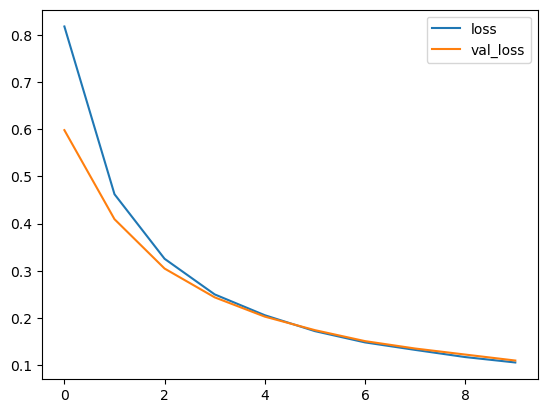

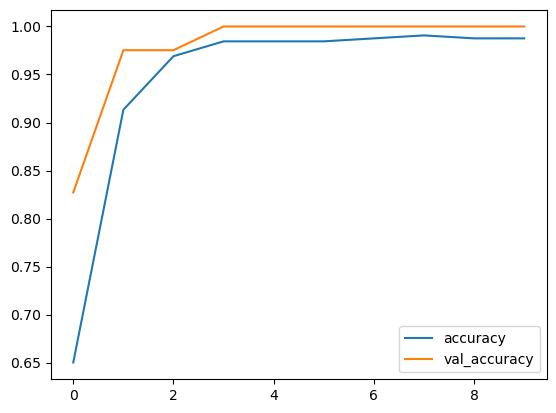

In [18]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show

In [19]:
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

3/3 [==============================] - 1s 264ms/step - loss: 0.1101 - accuracy: 1.0000
Validation Loss:0.11012028157711029 Validation Accuracy:1.0


In [20]:
# Get true labels
y_true = np.concatenate([y for x, y in valid_ds], axis=0)

# Get model predictions (convert logits to class indices)
y_pred_logits = efficient_net_model.predict(valid_ds)
y_pred = np.argmax(y_pred_logits, axis=1)  # Convert logits to class indices

# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", class_report)

3/3 [==============================] - 3s 261ms/step
Classification Report:
                 precision    recall  f1-score   support

ApplyEyeMakeup       1.00      1.00      1.00        36
 ApplyLipstick       1.00      1.00      1.00        18
       Archery       1.00      1.00      1.00        27

      accuracy                           1.00        81
     macro avg       1.00      1.00      1.00        81
  weighted avg       1.00      1.00      1.00        81



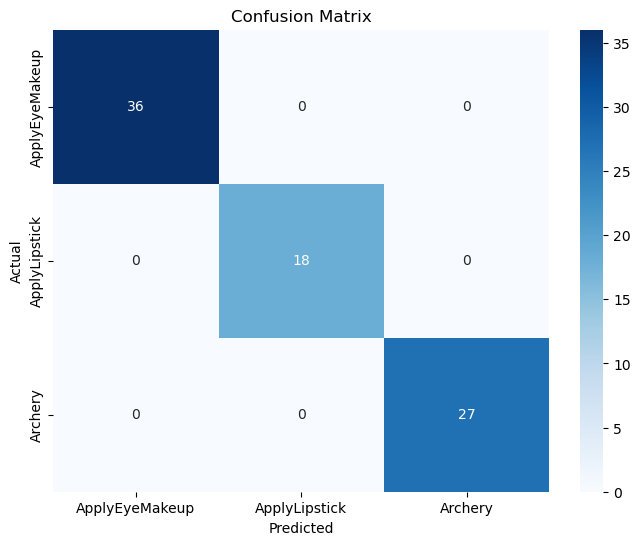

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Real Time Detection System

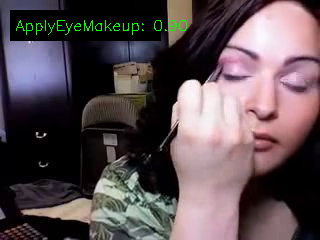

Processing complete! Output saved as 'output.avi'.


In [26]:
import cv2
import numpy as np
import tensorflow as tf
import time
from IPython.display import display, clear_output

def detect_video(video_path, model, class_names, n_frames=10, output_size=(224, 224), frame_step=15):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Define video writer for output (optional)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while cap.isOpened():
        frames = []
        for _ in range(n_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, output_size)
            frame_resized = frame_resized / 255.0  # Normalize
            frames.append(frame_resized)

        if len(frames) < n_frames:
            break  # Stop if not enough frames

        frames = np.array(frames)
        frames = np.expand_dims(frames, axis=0)  # Add batch dimension

        # Predict
        predictions = model.predict(frames)
        class_idx = np.argmax(predictions)
        confidence = np.max(tf.nn.softmax(predictions))

        # Read frame again for display
        ret, frame = cap.read()
        if not ret:
            break
                
        # Draw a black rectangle for the label
        cv2.rectangle(frame, (10, 10), (160, 40), (0, 0, 0), -1)  # Background box
        
        # Draw prediction text in the top-left corner (smaller font)
        text = f"{class_names[class_idx]}: {confidence:.2f}"
        cv2.putText(frame, text, (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Write to output file
        out.write(frame)

        # Display frame in Jupyter
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_frame(frame_rgb)

        # Add small delay for smooth playback
        time.sleep(0.03)

    cap.release()
    out.release()
    print("Processing complete! Output saved as 'output.avi'.")

def display_frame(frame_rgb):
    """ Helper function to display video frames inline in Jupyter Notebook """
    clear_output(wait=True)
    import PIL.Image
    img = PIL.Image.fromarray(frame_rgb)
    display(img)


# Example usage
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi", efficient_net_model, classes)

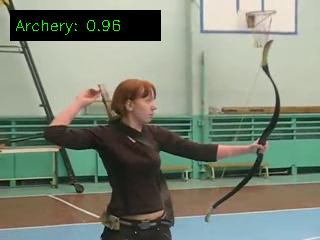

Processing complete! Output saved as 'output.avi'.


In [27]:
# Example usage
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/Archery/v_Archery_g01_c04.avi", efficient_net_model, classes)

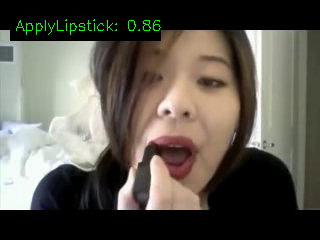

Processing complete! Output saved as 'output.avi'.


In [28]:
# Example usage
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/ApplyLipstick/v_ApplyLipstick_g01_c04.avi", efficient_net_model, classes)